In [1]:
import cv2
from urllib.request import urlopen
from PIL import Image
import IPython
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
from keras.datasets import mnist, fashion_mnist
import random
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from sklearn.datasets import make_blobs
from mlxtend.plotting import plot_decision_regions
import tensorflow as tf
print(tf.__version__)
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2.16.1


In [2]:
def generate_multiclass_blobs(num_samples_total, training_split, cluster_centers, num_classes, loss_function_used):
    X, targets = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 1.5)
    categorical_targets = to_categorical(targets)
    X_training = X[training_split:, :]
    X_testing = X[:training_split, :]
    Targets_training = categorical_targets[training_split:]
    Targets_testing = categorical_targets[:training_split].astype(np.int32)
    return X_training, Targets_training, X_testing, Targets_testing


def generate_binary_blobs(num_samples_total, training_split, loss_function_used):
    X, targets = make_blobs(n_samples = num_samples_total, centers = [(0,0), (15,15)], n_features = 2, center_box=(0, 1), cluster_std = 2.5)
    targets[np.where(targets == 0)] = -1
    X_training = X[training_split:, :]
    X_testing = X[:training_split, :]
    Targets_training = targets[training_split:]
    Targets_testing = targets[:training_split]
    return X_training, Targets_training, X_testing, Targets_testing

## Categorical Cross-EntropyWhen working on a machine learning problem, we use loss functions to optimize our models during training where a common objective is to minimize the loss function.

Cross-entropy is a widely used loss or cost function, that is used to optimize classification models. Before delving into cross-entropy, let us first cover the prerequisites by learning about a common activation function called Softmax.



### Softmax Activation FunctionActivation functions are transformations applied to the output from CNNs before loss computations.

The Softmax activation function is typically placed as the last layer in a neural network and used to normalize the output of a network to a probability distribution over predicted output classes.

It does so by scaling numbers/logits into probabilities for each possible outcome or class present in our dataset. The resulting probabilities in the vector sum up to one.

Mathematically, Softmax is defined as follows:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/softmax.png" style="width: 30%">




Here, $\overrightarrow{{z}}$ is an input vector to the Softmax function $\sigma$.

$\overrightarrow{{z}}\_i$ represents the $i$th element of the input vector, and can take on values from -inf to inf.

$\overrightarrow{{z}}_i$ represents the $i$th element of the input vector, and can take on values from -inf to inf. 

$e^{z_i}$ is a standard exponential function applied on the $i$th element of $z$, and the denominator is a normalizing term (L1-norm) to ensure the result is a valid probability distribution, that is, sums up to 1, and values are within the 0 - 1 range.


Exponential is a steeply increasing function; that is, it increases the difference between outputs. In the final output, the largest element (which dominates the norm) is normalized to a value close to 1, while all the other elements end up being close to 0. Not only does the resulting vector show the winning class, but it also retains the original order of values.


Another important point to note is that Softmax is not affected by negative values, as the exponent of any value is always a positive value.


Let us walk through an example to understand Softmax.
Imagine you are building a CNN model to classify an image as a dog, cat, fish, or horse. The fully-connected layer of your CNN gives a vector of logits. You pass the vector through the Softmax function above to obtain probabilities.
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/cce_diag.png)
### One-Hot Encoding





The ground truth is typically presented in form of categorical data; that is, a given image is categorized into one of these classes: dog, cat, fish, or horse.
For categorical variables where no ordinal relationships exist, we can perform one-hot encoding to represent each class. This is best explained through an example.

In our case, we will have four classes, and these are the corresponding one-hot encoded labels:



<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/ohe_labels.png" style="width: 50%">


So in one-hot encoding, we represent labels with a binary variable where for every given class, we have the value 1 for the position corresponding to that particular class and 0 elsewhere (that is, 100% probability of belonging to that class).


### Back to Categorical Cross-Entropy
Now that we have converted the logits to output probabilities, we need to measure how good they are; that is, measure the distance from the truth values.

For instance, in the example above, the desired output is [1,0,0,0], but the model outputs [0.775,0.116,0.039,0.070].
The categorical cross-entropy is mathematically defined as follows:<br>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/cce.png" style="width: 30%"><br>
We can use the formula above to compute the cross-entropy loss. When training our model, we iteratively update the weights to minimize the cross-entropy loss. 

The Softmax is continuously differentiable, and this property makes it easy to compute the derivative of the loss function and, accordingly, adjust the model weights in each iteration to minimize the loss function.

In the next iteration, if our $$L\_{CE}$$ is lower than the current one, we say that the model is *learning*.







## Binary vs. Multi-Class Classification

Now, let us do a quick review of binary and multi-class classification. Binary classification tasks require that all examples be assigned to one of two classes, whereas in multi-class classification, examples can belong to more than two classes.

For binary classification problems, we have a final layer with a single node and a sigmoid activation function. It can map the output vector from a CNN to values between 0 and 1 before loss computations. The sigmoid function is denoted using the following formula:

$$\sigma(x) = 1/(1+e^{-x}
Let's see binary classification and multi-class classification in action.
### Binary Classification
Using a helper function defined at the beginning of the notebook, we will use the `make_blobs()` function from `sklearn` to generate isotropic Gaussian blobs for classification.

We will create a data set with 1000 samples, and use 750 of those samples for training a simple CNN model
Let us define a few more configuration options.
*   **num_samples**: refers to the total number of samples in our dataset
*   **test_split**: refers to the number of samples to be used for testing
*   **cluster_centers**: we define 2 centers for our isotropic Gaussian blobs
*   **num_classes**: we have 2 classes
*   **loss_function_used**: since this is a binary classification problem, we use binary cross-entropy loss

.


)$$


In [3]:
num_samples = 1000
test_split = 250
cluster_centers = [(15,0), (30,15)]
num_classes = len(cluster_centers)
loss_function_used = BinaryCrossentropy(from_logits=True)

In [4]:
X_training, Targets_training, X_testing, Targets_testing=generate_binary_blobs(num_samples, test_split, loss_function_used)

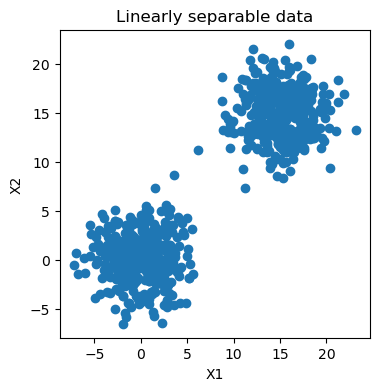

In [5]:
plt.figure(figsize=(4, 4))
plt.scatter(X_training[:,0], X_training[:,1])
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

We will build a simple CNN model with two hidden layers, that uses sigmoid as the activation function, and binary cross-entropy as the loss function. Let's define the architecture of our model:


In [6]:
feature_vector_shape = X_training.shape[1]
input_shape = (feature_vector_shape,)

model = Sequential()
model.add(Dense(12, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation = 'sigmoid'))

C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_training, Targets_training, epochs=30, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/30


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5096 - loss: -0.5702 - val_accuracy: 0.4533 - val_loss: -31.1484
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5027 - loss: -85.8395 - val_accuracy: 0.4600 - val_loss: -592.4667
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5550 - loss: -815.2139 - val_accuracy: 0.3800 - val_loss: -2816.8074
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5101 - loss: -3422.4229 - val_accuracy: 0.4533 - val_loss: -7789.9497
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4828 - loss: -8538.2822 - val_accuracy: 0.4600 - val_loss: -16441.6172
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: -16933.7168 - val_accuracy: 0.4333 - val_loss: -29790.7637
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4833 - loss: -31672.1152 - val_accuracy: 0.4600 - val_loss: -47936.5117
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [8]:
test_results = model.evaluate(X_testing, Targets_testing, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4536 - loss: -2744298.2500  
Test results - Loss: -2646501.25 - Accuracy: 45.19999921321869%


9600/9600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


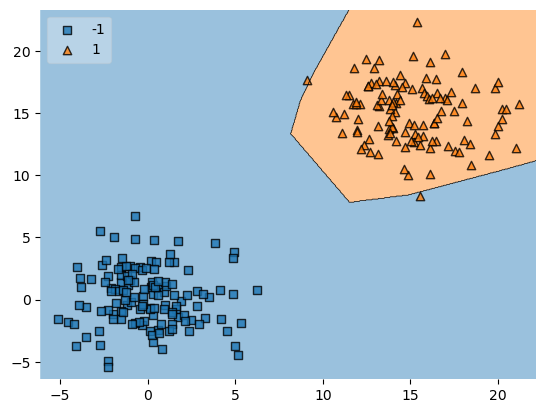

<Figure size 400x400 with 0 Axes>

In [9]:
plot_decision_regions(X_testing, Targets_testing, clf=model, legend=2)
plt.figure(figsize=(4, 4))
plt.show()

### Multi-Class Classification
Similar to binary classification, let's create another data set with 1000 samples, and use 750 of those samples for training a simple CNN model.<br>
Let us define a few more configuration options.<br>
*   **num_samples**: refers to the total number of samples in our dataset
*   **test_split**: refers to the number of samples to be used for testing
*   **cluster_centers**: we define 3 centers for our isotropic Gaussian blobs
*   **num_classes**: we have 3 classes
*   **loss_function_used**: since this is a multi-class classification problem, we use categorical cross-entropy loss





In [10]:
num_samples = 1000
train_split = 250
cluster_centers = [(-10, 5), (0, 0), (10, 5)]
num_classes = len(cluster_centers)
loss_function_used = CategoricalCrossentropy(from_logits=True)

In [11]:
X_training, Targets_training, X_testing, Targets_testing= generate_multiclass_blobs(num_samples, train_split,
              cluster_centers, num_classes,
              loss_function_used)

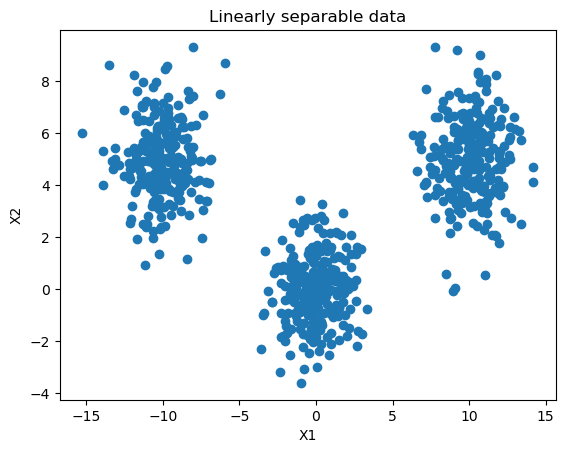

In [12]:
plt.scatter(X_training[:,0], X_training[:,1])
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [13]:
feature_vector_shape = X_training.shape[1]
input_shape = (feature_vector_shape,)

model = Sequential()
model.add(Dense(12, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_training, Targets_training, epochs=30, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/30


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5155 - loss: 0.8509 - val_accuracy: 0.6267 - val_loss: 0.7304
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7176 - loss: 0.6449 - val_accuracy: 0.7800 - val_loss: 0.6459
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.5666 - val_accuracy: 0.8400 - val_loss: 0.5810
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.5331 - val_accuracy: 0.8533 - val_loss: 0.5159
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9010 - loss: 0.4598 - val_accuracy: 0.9533 - val_loss: 0.4478
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9616 - loss: 0.4034 - val_accuracy: 0.9867 - val_loss: 0.3849
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.3307 - val_accuracy: 1.0000 - val_loss: 0.3180
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.2807 - val_accuracy: 1.0000 - val_

In [15]:
test_results = model.evaluate(X_testing, Targets_testing, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021  
Test results - Loss: 0.001899411203339696 - Accuracy: 100.0%


In [16]:
class Onehot2Int(object):

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)

# fit keras_model
keras_model_no_ohe = Onehot2Int(model)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


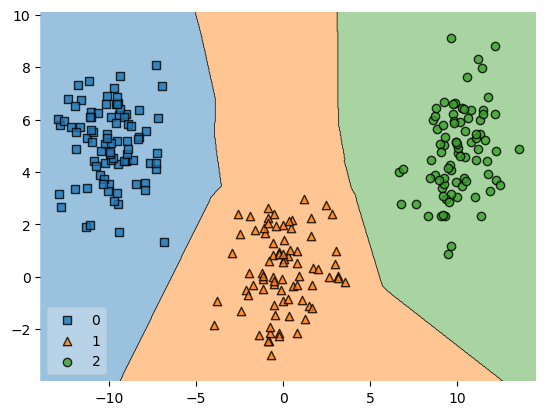

In [17]:
# Plot decision boundary
plot_decision_regions(X_testing, np.argmax(Targets_testing, axis=1), clf=keras_model_no_ohe, legend=3)
plt.show()

## Example: MNIST Hand-Written Digits

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

In [19]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


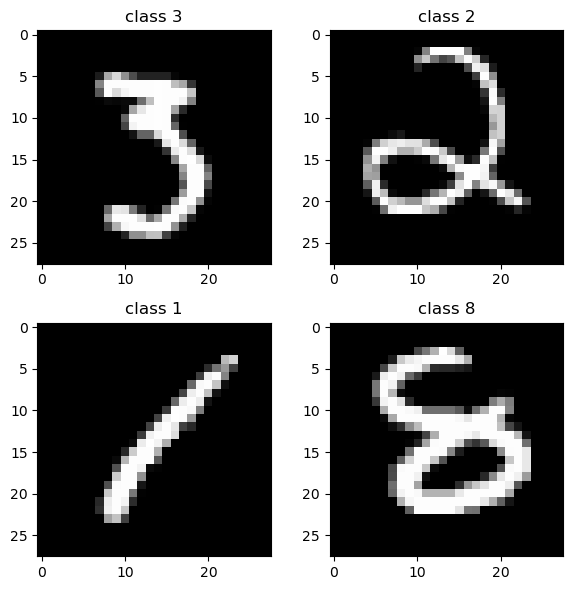

In [20]:
plt.rcParams['figure.figsize'] = (6,6) 

for i in range(4):
    plt.subplot(2,2,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("class {}".format(y_train[num]))
    
plt.tight_layout()

In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]* X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [23]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))
print(enc.categories_)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]


In [24]:
y_train_enc = enc.transform(y_train.reshape(-1,1))
y_test_enc = enc.transform(y_test.reshape(-1,1))

import numpy as np
y_train_enc = y_train_enc.toarray().astype('float32')
y_test_enc = y_test_enc.toarray().astype('float32')

# Or if you want integer labels, you can use the inverse_transform function
# y_train_enc = enc.inverse_transform(y_train_enc).reshape(-1).astype('float32')
# y_test_enc = enc.inverse_transform(y_test_enc).reshape(-1).astype('float32')


In [25]:
feature_vector_shape = X_train.shape[1]
input_shape = (feature_vector_shape,)
num_classes = 10
loss_function_used=CategoricalCrossentropy(from_logits=True)
model = Sequential()
model.add(Dense(12, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train_enc, epochs=25, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/25


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9600/9600 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7473 - loss: 0.7805 - val_accuracy: 0.9104 - val_loss: 0.3165
Epoch 2/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9088 - loss: 0.3181 - val_accuracy: 0.9220 - val_loss: 0.2804
Epoch 3/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9184 - loss: 0.2813 - val_accuracy: 0.9203 - val_loss: 0.2715
Epoch 4/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9256 - loss: 0.2602 - val_accuracy: 0.9223 - val_loss: 0.2710
Epoch 5/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9284 - loss: 0.2510 - val_accuracy: 0.9253 - val_loss: 0.2600
Epoch 6/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9312 - loss: 0.2394 - val_accuracy: 0.9304 - val_loss: 0.2442
Epoch 7/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9357 - loss: 0.2268 - val_accuracy: 0.9323 - val_loss: 0.2370
Epoch 8/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9377 - loss: 0.2198 - val

## Example: Single-Digit House Number Recognition

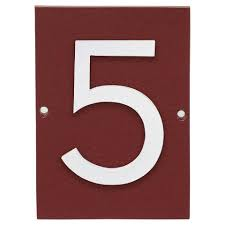

In [27]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/house_number_5.jpeg'
image = Image.open(urlopen(URL)).convert('RGB')
image

In [28]:
feature_vector_shape, input_shape = 784, 784
num_classes = 10
loss_function_used = CategoricalCrossentropy(from_logits=True)

model = Sequential()
model.add(Dense(12, input_shape=(input_shape,), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train_enc, epochs=25, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.7408 - loss: 0.8127 - val_accuracy: 0.9165 - val_loss: 0.2861
Epoch 2/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9226 - loss: 0.2700 - val_accuracy: 0.9302 - val_loss: 0.2347
Epoch 3/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9327 - loss: 0.2270 - val_accuracy: 0.9396 - val_loss: 0.2124
Epoch 4/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9350 - loss: 0.2186 - val_accuracy: 0.9415 - val_loss: 0.2124
Epoch 5/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9414 - loss: 0.1996 - val_accuracy: 0.9318 - val_loss: 0.2392
Epoch 6/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9444 - loss: 0.1901 - val_accuracy: 0.9423 - val_loss: 0.2093
Epoch 7/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9459 - loss: 0.1838 - val_accuracy: 0.9440 - val_loss: 0.2005
Epoch 8/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9451 - loss: 0

In [29]:
img_rows, img_cols = 28, 28
img = Image.fromarray(np.uint8(image)).convert('L')
img_gray = img.resize((img_rows, img_cols), Image.ANTIALIAS)
img_gray

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [ ]:
arr = np.array(img_gray)
arr = arr.reshape((img_cols*img_rows))
arr = np.expand_dims(arr, axis=0)

In [ ]:
prediction = model.predict(arr)
np.argmax(prediction)

# Exercises


### Exercise 1 - Loading and plotting the images


In [30]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

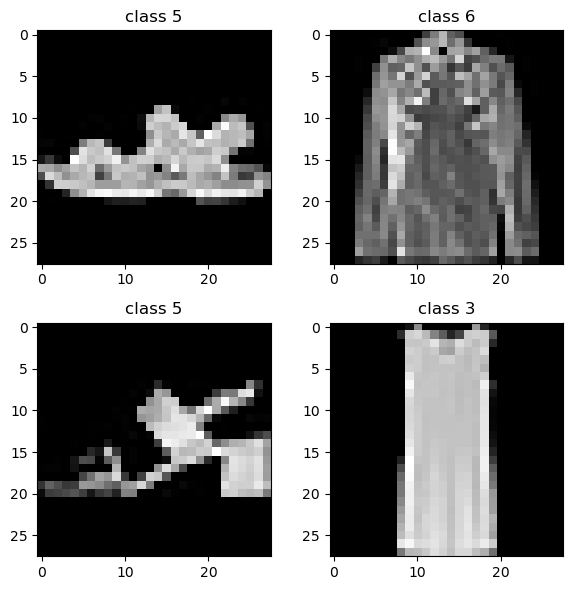

In [31]:
plt.rcParams['figure.figsize'] = (6,6) 

for i in range(4):
    plt.subplot(2,2,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("class {}".format(y_train[num]))
    
plt.tight_layout()

### Exercise 2 - Preparing the data


In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [33]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

### Exercise 3 - One-hot encoding


In [40]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))
print(enc.categories_)
y_train_enc = enc.transform(y_train.reshape(-1,1))
y_test_enc = enc.transform(y_test.reshape(-1,1))

y_train_enc = enc.transform(y_train.reshape(-1,1))
y_test_enc = enc.transform(y_test.reshape(-1,1))

import numpy as np
y_train_enc = y_train_enc.toarray().astype('float32')
y_test_enc = y_test_enc.toarray().astype('float32')

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]


### Exercise 4 - Build model architecture


Build a CNN model with 2 hidden layers, that uses softmax as the activation function, and categorical cross-entropy as the loss function.

In [41]:
feature_vector_shape = X_train.shape[1]
input_shape = (feature_vector_shape,)
num_classes = 10
loss_function_used = CategoricalCrossentropy(from_logits=True)

model = Sequential()
model.add(Dense(12, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train_enc, epochs=25, batch_size=5, verbose=1, validation_split=0.2)

test_results = model.evaluate(X_test, y_test_enc, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9600/9600 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6984 - loss: 0.8396 - val_accuracy: 0.8266 - val_loss: 0.4823
Epoch 2/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.8318 - loss: 0.4775 - val_accuracy: 0.8355 - val_loss: 0.4672
Epoch 3/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8448 - loss: 0.4358 - val_accuracy: 0.8540 - val_loss: 0.4180
Epoch 4/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8558 - loss: 0.4073 - val_accuracy: 0.8473 - val_loss: 0.4311
Epoch 5/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.8605 - loss: 0.3897 - val_accuracy: 0.8509 - val_loss: 0.4127
Epoch 6/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8642 - loss: 0.3842 - val_accuracy: 0.8472 - val_loss: 0.4181
Epoch 7/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8652 - loss: 0.3694 - val_accuracy: 0.8562 - val_loss: 0.4011
Epoch 8/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.8699 - loss: 0.3612 - val

### (Optional) Exercise 5 - Sparse Categorical Cross Entropy
We saw that when using categorical cross-entropy, the ground truth labels need to be one-hot encoded. Keras provides another loss function called sparse cross-entropy where we can leave the labels as integers.

Build a CNN model with two hidden layers, that uses softmax as the activation function, and sparse categorical cross-entropy as the loss function. Make sure to use the non-one-hot encoded ground-truth labels.  


In [43]:
feature_vector_shape = X_train.shape[1]
input_shape = (feature_vector_shape,)
num_classes = 10
loss_function_used = SparseCategoricalCrossentropy(from_logits=True)

model = Sequential()
model.add(Dense(12, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

In [45]:
y_train_indices = np.argmax(y_train_enc, axis=1)

y_test_indices = np.argmax(y_test_enc, axis=1)
model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train_indices, epochs=25, batch_size=5, verbose=1, validation_split=0.2)
test_results = model.evaluate(X_test, y_test_indices, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')


Epoch 1/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.6937 - loss: 0.8350 - val_accuracy: 0.8184 - val_loss: 0.5092
Epoch 2/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8299 - loss: 0.4832 - val_accuracy: 0.8401 - val_loss: 0.4579
Epoch 3/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8451 - loss: 0.4417 - val_accuracy: 0.8410 - val_loss: 0.4504
Epoch 4/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8556 - loss: 0.4011 - val_accuracy: 0.8472 - val_loss: 0.4206
Epoch 5/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8586 - loss: 0.3934 - val_accuracy: 0.8587 - val_loss: 0.4009
Epoch 6/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8633 - loss: 0.3760 - val_accuracy: 0.8616 - val_loss: 0.3933
Epoch 7/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.8665 - loss: 0.3660 - val_accuracy: 0.8606 - val_loss: 0.3955
Epoch 8/25
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.8668 - loss: 0